<a href="https://colab.research.google.com/github/lse-st455/hw7-vovagu7ev/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this homework assigment, you are required to apply the neural fitted Q-iteration algorithm to a pre-collected dataset for batch (offline) policy optimisation. Please follow the instructions detailed below.

Step 1: Generate an offline dataset. Consider the CartPole example. We will use a sub-optimal policy for data generation. Specifically, consider the following deterministic policy $\pi_b$ that returns 0 (left) if the pole angle is negative and 1 otherwise. To allow exploration, we set the behavior policy to be a mixture of $\pi_b$ and a uniform random policy. Specifically, the agent will follow the uniform random policy or $\pi_b$ with equal probability. We simulate 100 episodes under this policy. This yields the offline dataset.

Step 2: Fitted Q-iteration. We will apply the neural fitted Q-iteration (FQI) algorithm to this offline data to compute an optimal policy with three different choices of $\gamma$, corresponding to 0.95, 0.99 and 1. Please refer to Page 43 of Lecture 5 for the pseudocode of FQI in batch settings. We repeat the Q-iteration 20 times, e.g., apply supervised learning algorithms 20 times to learn the optimal Q-function. The initial Q-estimator can be set to a zero function. Each iteration yields a Q-estimator, based on which we can derive an estimated optimal policy. In total, we obtain 20 $\times$ 3 (3 choices of $\gamma$) different policies.

* To combine FQI with neural networks, we consider using the [MLPregressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) function. We can use the default neural network architecture (no need to specify no. of layers or no. of hidden nodes per layer). We may set the maximum number of iterations to 500.

* In this example, we only have two actions (either pushing the cart to the left or to the right). As such, it would be better to use the second type of value function approximators on Page 11 of Lecture 5 (e.g., for each action, use a separate model for the value). The last type of approximators would be preferred in settings where we have a large action space.

* The TD target depends on whether the current state is a terminal state or not. For a nonterminal state, the TD target is constructed as in the lecture slide. For a terminal state, the TD target is equal to the immediate reward.

Step 3: Policy evaluation. For each of the computed 60 policies, we use the Monte Carlo method to evaluate the expected return under this policy, by generating 1000 episodes. Finally, plot all the returns in a single figure and comment on the results.

# Step 1: Generate an offline dataset

In [ ]:
import gym
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

env = gym.make('CartPole-v1')


# set the random seed for reproducibility
random.seed(123)
np.random.seed(123)
env.seed(123)



def suboptimal_policy(observation):
    pole_angle = observation[2]
    action = 0 if pole_angle < 0 else 1
    return action


def mixture_policy(observation):
    if random.random() < 0.5:
        return suboptimal_policy(observation)
    else:
        return env.action_space.sample()


def generate_dataset(policy, num_episodes):
    dataset = []
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action = policy(obs)
            next_obs, reward, done, _ = env.step(action)
            dataset.append((obs, action, reward, next_obs, done))
            obs = next_obs
    return dataset


dataset = generate_dataset(mixture_policy, 100)
print("Dataset size: ", len(dataset))


Dataset size:  4052


# Step 2: Fitted Q-iteration

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


def fqi(dataset, gamma, num_iterations, max_iterations):
    # create separate datasets for states and actions
    states = np.array([data[0] for data in dataset])
    actions = np.array([data[1] for data in dataset])
    rewards = np.array([data[2] for data in dataset])
    next_states = np.array([data[3] for data in dataset])
    dones = np.array([data[4] for data in dataset])
    
    num_actions = env.action_space.n
    
    # initialize Q-estimator to zero function
    q_estimator = np.zeros((len(states), num_actions))
    
    q_estimators = [q_estimator]
    
    for iteration in range(num_iterations):
        print("Iteration ", iteration+1)
        
        # compute targets
        targets = np.zeros((len(states), num_actions))
        
        for action in range(num_actions):
            next_q = np.zeros((len(states), 1))
            for j in range(len(states)):
                if dones[j]:
                    next_q[j, 0] = rewards[j]
                else:
                    next_q[j, 0] = max(q_estimators[-1][j, :])
            targets[:, action] = rewards + gamma * next_q[:, 0]
        
        # fit MLPregressor to dataset
        mlp = MLPRegressor(max_iter=max_iterations)
        mlp.fit(np.hstack((states, actions.reshape(-1,1))), targets)
        
        # update Q-estimator
        q_estimator = mlp.predict(np.hstack((states, actions.reshape(-1,1))))
        q_estimators.append(q_estimator)
        
        # compute MSE
        mse = mean_squared_error(targets, q_estimator)
        print("MSE: ", mse)
        
    return q_estimators[1:]


gammas = [0.95, 0.99, 1.0]
num_iterations = 20
max_iterations = 500

q_estimators = []
for gamma in gammas:
    q_estimators.extend(fqi(dataset, gamma, num_iterations, max_iterations))


Iteration  1
MSE:  0.017471353531478898
Iteration  2
MSE:  0.0010498939423882812
Iteration  3
MSE:  0.019908723914142362
Iteration  4
MSE:  0.03936047112163024
Iteration  5
MSE:  0.028913018714285185
Iteration  6
MSE:  0.029990812438078412
Iteration  7
MSE:  0.04173824469941838
Iteration  8
MSE:  0.055405301253564604
Iteration  9
MSE:  0.05389541168187686
Iteration  10
MSE:  0.06581544690051121
Iteration  11
MSE:  0.09789000533346956
Iteration  12
MSE:  0.15318577408682793
Iteration  13
MSE:  0.09816132907348396
Iteration  14
MSE:  0.11822838561351204
Iteration  15
MSE:  0.12862619528448482
Iteration  16
MSE:  0.12165256986462031
Iteration  17
MSE:  0.14996805339290678
Iteration  18
MSE:  0.1234273011991287
Iteration  19
MSE:  0.14047783934864652
Iteration  20
MSE:  0.13599451995606665
Iteration  1
MSE:  0.01993059287648019
Iteration  2
MSE:  0.0010008072468019671
Iteration  3
MSE:  0.025256960025827998
Iteration  4
MSE:  0.030595507349168535
Iteration  5
MSE:  0.03515582070985311
Iter

# Step 3: Policy Evaluation.

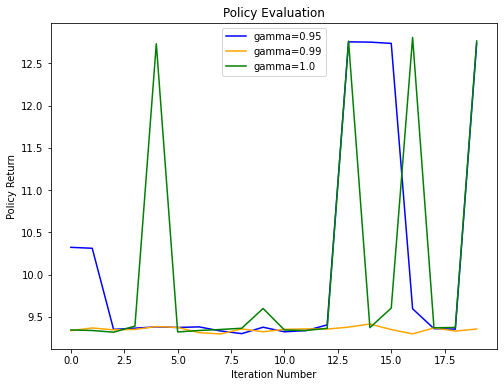

In [ ]:
import matplotlib.pyplot as plt

def evaluate_policy(policy, num_episodes):
    total_rewards = []
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = policy(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)


num_episodes_eval = 1000

policy_returns = []
for q_estimator in q_estimators:
    policy = lambda obs: int(np.clip(np.argmax(q_estimator[np.array(obs).reshape(1,-1).astype(int), :]), 0, 1))

    policy_return = evaluate_policy(policy, num_episodes_eval)
    policy_returns.append(policy_return)
    
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8,6))
for i in range(len(gammas)):
    start_index = i*num_iterations
    end_index = (i+1)*num_iterations
    plt.plot(range(num_iterations), policy_returns[start_index:end_index], color=colors[i], label="gamma={}".format(gammas[i]))
plt.xlabel("Iteration Number")
plt.ylabel("Policy Return")
plt.title("Policy Evaluation")
plt.legend()
plt.show()
